In [37]:
from IPython.display import HTML
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

<img src='carl-wunderlich-german-physician-science-source.jpg' width="300" height="300" align="center">

# What is the True Normal Human Body Temperature? 


In [36]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

import packages

In [296]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats 
from scipy.stats import truncnorm
import statsmodels.api as sm
import pylab
from statsmodels.stats.weightstats import ztest
from IPython.display import display, Math, Latex
#from numpy.random import randn
%matplotlib inline

import data

In [ ]:
df = pd.read_csv('data/human_body_temperature.csv')

**Is the distribution of body temperatures normal?**

    Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    
    Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test 

In [39]:
# Your work here.
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


*At first blush the mean body temperature appears to be approximately 96.3 degrees, with a standard deviation of .73. Which could means that 68% of observations seem to fall within 97.52 and 98.98.*

In [40]:
print('Among',df.temperature.count(),'observations:')
print('The mean of temperature:',df.temperature.mean())
print('The standard deviation of temperature:',df.temperature.std())
print('Therefore 68% of the temperature observations lie between',df.temperature.mean()-df.temperature.std(),'and',df.temperature.mean()+df.temperature.std(),'.')
df.describe()

Among 130 observations:
The mean of temperature: 98.24923076923078
The standard deviation of temperature: 0.7331831580389454
Therefore 68% of the temperature observations lie between 97.51604761119184 and 98.98241392726972 .


,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


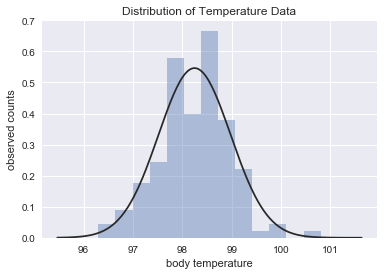

In [109]:
temp_array=np.array(df.temperature)
sns.set()
_ = sns.distplot(temp_array, kde=False, fit=stats.gamma)
_ = plt.title('Distribution of Temperature Data')
_ = plt.xlabel('body temperature')
_ = plt.ylabel('observed counts')

plt.show()

In [42]:
def boxPlot(variable):
    sns.set_style("whitegrid")
    #sns.load_dataset("tips")
    sns.boxplot(x=variable)
    return plt.show(),plt.clf()

In [43]:
def CDFPlot(variable):
    lower,upper=variable.min(),variable.max()
    mu,sigma = variable.mean(),variable.std()
    values = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
#    values = np.random.normal(mu, sigma, 10000)
    sns.kdeplot(variable,cumulative=True,label=variable.name+" CDF",color='b')
    sns.kdeplot(values.rvs(1000),cumulative=True,label="Gaussian CDF",color='r')
    plt.suptitle("Cumulative Distribution Frequency of Temperature Against Normal Gaussian distribution.")
    plt.figure()
    return plt.show(),plt.clf()

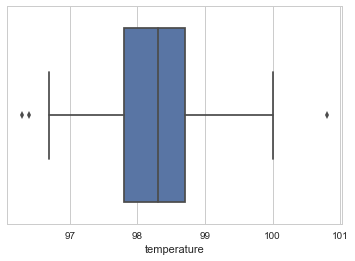

(None, None)

<Figure size 432x288 with 0 Axes>

In [44]:
boxPlot(df['temperature'])

In [57]:
Observed_Column=df.temperature
quartile_1=np.percentile(Observed_Column, 25)
quartile_3=np.percentile(Observed_Column, 75)
inter_quartile_range=quartile_3-quartile_1
Inner_fence=1.5*(inter_quartile_range)
Outer_fence=3*inter_quartile_range
#Fences for viewing outliers
#mild outliers
inner_lower_fence=quartile_1-Inner_fence
inner_upper_fence=quartile_3+Inner_fence
#strong outliers
outer_lower_fence=quartile_1-Outer_fence
outer_upper_fence=quartile_3+Outer_fence

In [97]:
print('Strong Outliers:')
print('There are no strong outliers.')
comparison=(df['temperature']<outer_lower_fence) | (df['temperature']>outer_upper_fence)
df[comparison]


Strong Outliers:
There are no strong outliers.


,temperature,gender,heart_rate


In [94]:
print('Mild Outliers:')
print('Median:',df.temperature.median())
print('Inner Fence:',inner_lower_fence,'&',inner_upper_fence)
comparison=(df['temperature']<inner_lower_fence) | (df['temperature']>inner_upper_fence)
df[comparison]

Mild Outliers:
Median: 98.3
Inner Fence: 96.44999999999999 & 100.05000000000001


,temperature,gender,heart_rate
39,96.4,F,69.0
116,100.8,F,77.0
125,96.3,M,70.0


**Description**: Above we can see mild outliers for **temperature** that will have a *dragging effect* on the distribution.

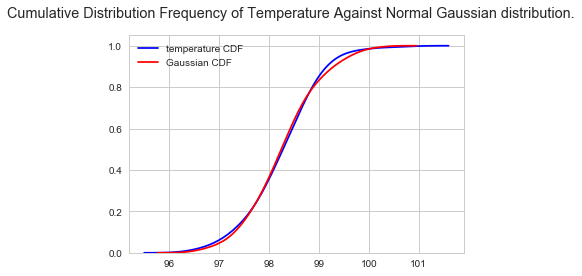

<Figure size 432x288 with 0 Axes>

(None, None)

<Figure size 432x288 with 0 Axes>

In [45]:
CDFPlot(df['temperature'])

In [92]:
print('Here we can see how different the',df['temperature'].max(),'observation is from the other observations. ')

Here we can see how different the 100.8 observation is from the other observations. 


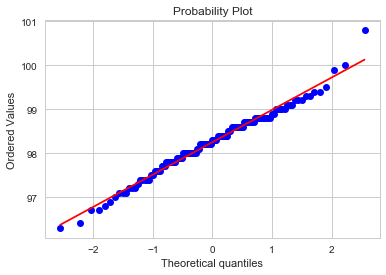

In [93]:
stats.probplot(df['temperature'], dist="norm", plot=pylab)
pylab.show()

It would appear as though the observations fall within a roughly normal Gaussian curve. 

In [235]:
from scipy import stats
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
norm=stats.normaltest(df.temperature)
print('test statistic: ',norm[0])
if(norm[1] < 0.055):
    print("P-value: ",norm[1],"\nConclusion: Not a normal distribution.")
else:
    print("P-value: ",norm[1],"\nConclusion: A normal distribution.")

test statistic:  2.703801433319203
P-value:  0.2587479863488254 
Conclusion: A normal distribution.


**Is the sample size large? Are the observations independent?**

        Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply. 

I don't need to run a statistical test to tell you that the sample size *(n=130)* is small for describing the world's population; even for the German population in 1868 which probably ranged between 30 and 40 million.
https://en.wikipedia.org/wiki/Demographics_of_Germany

For representing the population of Germany *(30 million)* at the time I would probably want to have a sample of *at least* 500 observations to do a population study.
(https://www.research-advisors.com/tools/SampleSize.htm) However, for a simple one-sided statistical test we would need at least a sample of 30 observations for the central limit theorem to apply; which we do.

I think it is important to point out that this data is small compared to Wunderlich's original data set of 25,000 individuals and several million observations.
https://pdfs.semanticscholar.org/dfa9/deb7ab1ca1a83a54aca52e8bff8e92e81a8e.pdf

** Perhaps it would be better to rephrase the inherent question. Rather than making claims from the data about the body temperature of normal individuals at the population level (Germany or *all humans*); we can see if our data is are consistent with Wunderlich's estimates. **

    N= 25,000
    Mean=98.6
    

*According to Wunderlich, women have slightly higher normal temperatures than men and often show greater and more sudden changes in temperature*

**Independance**
- The individual observations are independant from each other, by that, on person's personal temperature measurement can't possibly have an effect on anothers unless perhaps they were doing a convenience sample and they all got sick from one of the people in the study. 

- Since our sample is far less than 10% of the total population we can assume that the observations are statistically independant.

- I think it is important also to know that Wunderlich didn't describe his sampling methods in his data so there is no true reason to assume the observations are truly independant in nature and there could be repeat observations of individuals from different parts of the body. *(He measured the temperature from the body extremities with a mercury themometer as opposed to orally.)*

**Randomness**
- As pointed out previously, we don't know Wunderlich's sampling methodology, most likely a convenience sample, where he observed patients within his clinic and recorded the observations. I think you could make a justifiable case that if they were a sample of convenience that the observations although random, may be biased because individuals go to the doctor's office because they are sick and not because they are healthy.

**Normal**
- The original population is most likely a normal distribution.
- The sample size is greater than 30.
- As previously explored the sampling distribution visually appears to be roughly normal. There are outliers but not strong outliers.




**Is the true population mean really 98.6 degrees F?**

- First, try a bootstrap hypothesis test.
- Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why? 
- In this situation, is it appropriate to use the t or z statistic? 
- Now try using the other test. How is the result be different? Why? 

*Note: We don't know what the true population mean is since we only can calculate figures from a sample of the true population.*

**For this test using a one-sided t-test is most appropriate since we are comparing against a single population estimate of 98.6 without any other information given about the distribution or data.**

In [315]:
print('If we fail to reject the null hypothesis then the data would seem consistent with the claim that the sample population body temperature is equivalent to 98.6. ')
Math(r'H_{0} : \mu_{w} - \bar x_{s} = 0 \\ H_{1} : \mu_{w} > \bar x_{s} ')


If we fail to reject the null hypothesis then the data would seem consistent with the claim that the sample population body temperature is equivalent to 98.6. 


<IPython.core.display.Math object>

Bootstrap hypothesis test

In [183]:
# Generate 25,000 bootstrap replicates of the variance: bs_replicates
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

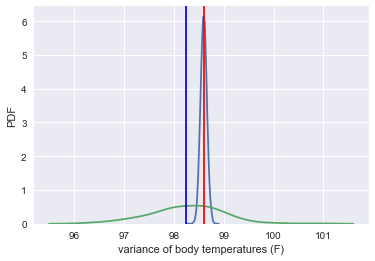

p =  0.0
Our sample mean: 98.24923076923078 (blue)
Wunderlich's mean: 98.6 (red)
Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).


In [247]:
# Make an array of translated temperatures
translated_force_b = df.temperature - np.mean(df.temperature) + 98.6
# Take bootstrap replicates of our sample temperatures translated
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 25000)
# Compute fraction of replicates that are less than the observed 
p = np.sum(bs_replicates <= np.mean(df.temperature)) / 25000

# Make a histogram of the results
#_ = plt.hist(bs_replicates, normed=True, bins=50)
_ = sns.distplot(bs_replicates, hist=False, rug=False)
_ = sns.distplot(df.temperature, hist=False, rug=False)
_ = plt.xlabel('variance of body temperatures (F)')
_ = plt.ylabel('PDF')
_ = plt.axvline(98.6, 0,6,color='red')
_ = plt.axvline(df.temperature.mean(), 0,6,color='blue')
# Show the plot
plt.show()

# Print the p-value
print('p = ', p)
if p<.05:
    print('Our sample mean:',df.temperature.mean(), '(blue)')
    print("Wunderlich's mean:",98.6,'(red)')
    print("Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).")
else:
    print("Conclusion: We fail reject the null hypothesis and find that the data is consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).")

Frequentist statistical testing

In [287]:
Math(r't: = \dfrac{(x_i - \mu_i)}{ \dfrac{s_i}{ \sqrt{n}}}')

<IPython.core.display.Math object>

In [301]:
#from table 95% confidence interval with 129 degrees of freedom=1.980
ttest = (df.temperature.mean() - 98.6) / (df.temperature.std() / np.sqrt(df.temperature.count()))

ttest = stats.ttest_1samp(df.temperature, popmean=98.6)
print('t-statistic:', ttest[0],' \n p-value:', ttest[1])
if ttest[1]<.05:
    print('Our sample mean:',df.temperature.mean())
    print("Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).")
else:
    print("Conclusion: We fail reject the null hypothesis and find that the data is consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).")

t-statistic: -5.4548232923645195  
 p-value: 2.4106320415561276e-07
Our sample mean: 98.24923076923078
Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).


In [289]:
Math(r'z: = \dfrac{x_i - \mu_i}{s_i}')

<IPython.core.display.Math object>

In [305]:
z = (df.temperature.mean() - 98.6) / (df.temperature.std())
z=ztest(df.temperature,value=98.6)
print('z-statistic:', z[0],' \n p-value:', z[1])
if z[1]<.05:
    print('Our sample mean:',df.temperature.mean())
    print("Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).")
else:
    print("Conclusion: We fail reject the null hypothesis and find that the data is consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).")

z-statistic: -5.4548232923645195  
 p-value: 4.9021570141012155e-08
Our sample mean: 98.24923076923078
Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).


In [308]:
print('If we fail to reject the null hypothesis then the data would seem consistent with the claim that the sample population body temperature is equivalent to 98.6. ')
Math(r'H_{0} : \mu_{w} - \bar x_{s} = 0 \\ H_{1} : \mu_{w} - \bar x_{s} \neq 0')


If we fail to reject the null hypothesis then the data would seem consistent with the claim that the sample population body temperature is equivalent to 98.6. 


<IPython.core.display.Math object>

*Note: this has to be done comparing the replicate distribution and sample distribution.*

In [319]:
Math(r'T = \frac{\bar{Y_{1}} - \bar{Y_{2}}}{\sqrt{{s^{2}_{1}}/N_{1} + {s^{2}_{2}}/N_{2}}}')

<IPython.core.display.Math object>

In [328]:
ttest = stats.ttest_ind(df.temperature, bs_replicates)

print('t-statistic:', ttest[0],' \n p-value:', ttest[1])
if ttest[1]<.05:
    print('Our sample mean:',df.temperature.mean())
    print("Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).")
else:
    print("Conclusion: We fail reject the null hypothesis and find that the data is consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).")

t-statistic: -48.13575244243265  
 p-value: 0.0
Our sample mean: 98.24923076923078
Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample mean is equivalent to Wunderlich's average body temperature of 98.6(F).


**Draw a small sample of size 10 from the data and repeat both frequentist tests.**

- Which one is the correct one to use?
- What do you notice? What does this tell you about the difference in application of the t and z statistic? 

In [330]:
srs = np.random.choice(x, size=10)
srs

array([98.2, 97.9, 98.2, 98. , 98.1, 97.9, 97.8, 98.2, 98.8, 98.5])

The results are roughly equivalent but the t-test provides a more conservative estimate and can hand small sample sizes more effectively.

In [333]:
z=ztest(df.temperature,value=98.6)
print('z-statistic:', z[0],' p-value:', z[1])
ttest = stats.ttest_1samp(df.temperature, popmean=98.6)
print('t-statistic:', ttest[0],'  p-value:', ttest[1])


z-statistic: -5.4548232923645195  p-value: 4.9021570141012155e-08
t-statistic: -5.4548232923645195   p-value: 2.4106320415561276e-07


**At what temperature should we consider someone's temperature to be "abnormal"?**
- As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
- Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws. 

In [346]:
lower_bound=df.temperature.mean()-df.temperature.std()
upper_bound=df.temperature.mean()+df.temperature.std()
print('Observations between',lower_bound,'and',upper_bound,'would be considered normal.')

Observations between 97.51604761119184 and 98.98241392726972 would be considered normal.


**Is there a significant difference between males and females in normal temperature?**

- What testing approach did you use and why?
- Write a story with your conclusion in the context of the original problem. 

In [366]:
print('If we fail to reject the null hypothesis then the data would seem consistent with the claim that our two sample body temperatures are equivalent.')
Math(r'H_{0} : \bar x_{males} - \bar x_{femals} = 0 \\ H_{1} : \bar x_{males} - \bar x_{females} \neq 0')


If we fail to reject the null hypothesis then the data would seem consistent with the claim that our two sample body temperatures are equivalent.


<IPython.core.display.Math object>

In [364]:
males=df.gender == 'M'
males = df.temperature[males]
females=df.gender == 'F'
females = df.temperature[females]

ttest = stats.ttest_ind(males, females)
print('t-statistic:',ttest[0],'\np-value:',ttest[1])
if ttest[1]<.05:
    print('Male Mean: '+str(np.mean(males))+'\nFemale Mean: '+str(np.mean(females)))
    print("Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample means are equivalent.")
else:
    print("Conclusion: We fail to reject reject the null hypothesis and find that the data is not consistent with the claim that our sample means are equivalent.")

t-statistic: -2.2854345381656103 
p-value: 0.02393188312239561
Male Mean: 98.1046153846154
Female Mean: 98.39384615384613
Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that our sample means are equivalent.


**Conclusion: The data show seem to show sufficient evidence to support the claim that the average body temperature is not 98.6, despite the convention. We also find further evidence to support the claim that male and femaile body temperatures are different from each other.**